# STA561 Lab 3: Cross Validation

The main goal of this lab is to review various forms of cross validation and learn to implement them in python using sklearn

*This lab is adapted from a previous STA 561 lab written by Yuhan Chen*

## Review of model fit

We have seen cross-validation (CV) as a tuning method for the hyperparameter $\lambda$ in the context of LASSO and ridge regression in Lab 1. For this lab, we'll be looking at another use case of CV, which is to evaluate a machine learning model and test its performance. It is also a powerful weapon to prevent underfitting or overfitting.

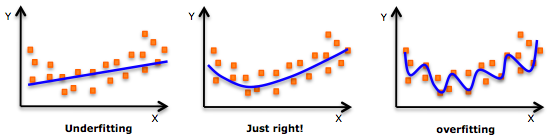

### Overfitting
When we overfit, this means that our model is modeling (has learned) the training data way too well, for example, the model has too many features and therefore is too complex. This model will be very accurate on the training data but will underperform on untrained or new data. An overfitted model learns the data but also the noise that is part of training data to the extent that it negatively impacts the performance of the model on new unseen data.


### Underfitting
On the other hand, there's the opposite phenomenon of underfitting when the model is too simple. When a model is underfitted, it means that the model does not fit the training data and misses out on key trends. Such a model would poorly generalize to new data. For example, we attempt to fit a linear model to data that is clearly not linear, we can expect poor predictive performances in such a situation.

### Model complexity vs. training/validation errors


Theoritically, as the model complexity goes up, the training error will go down, but the trend of validation/test error is not monotonic. Rather, it is a bell curve and exists a "sweet point" at which the validation/test error is the smallest. CV algorithms is a way to find such "sweet point". 
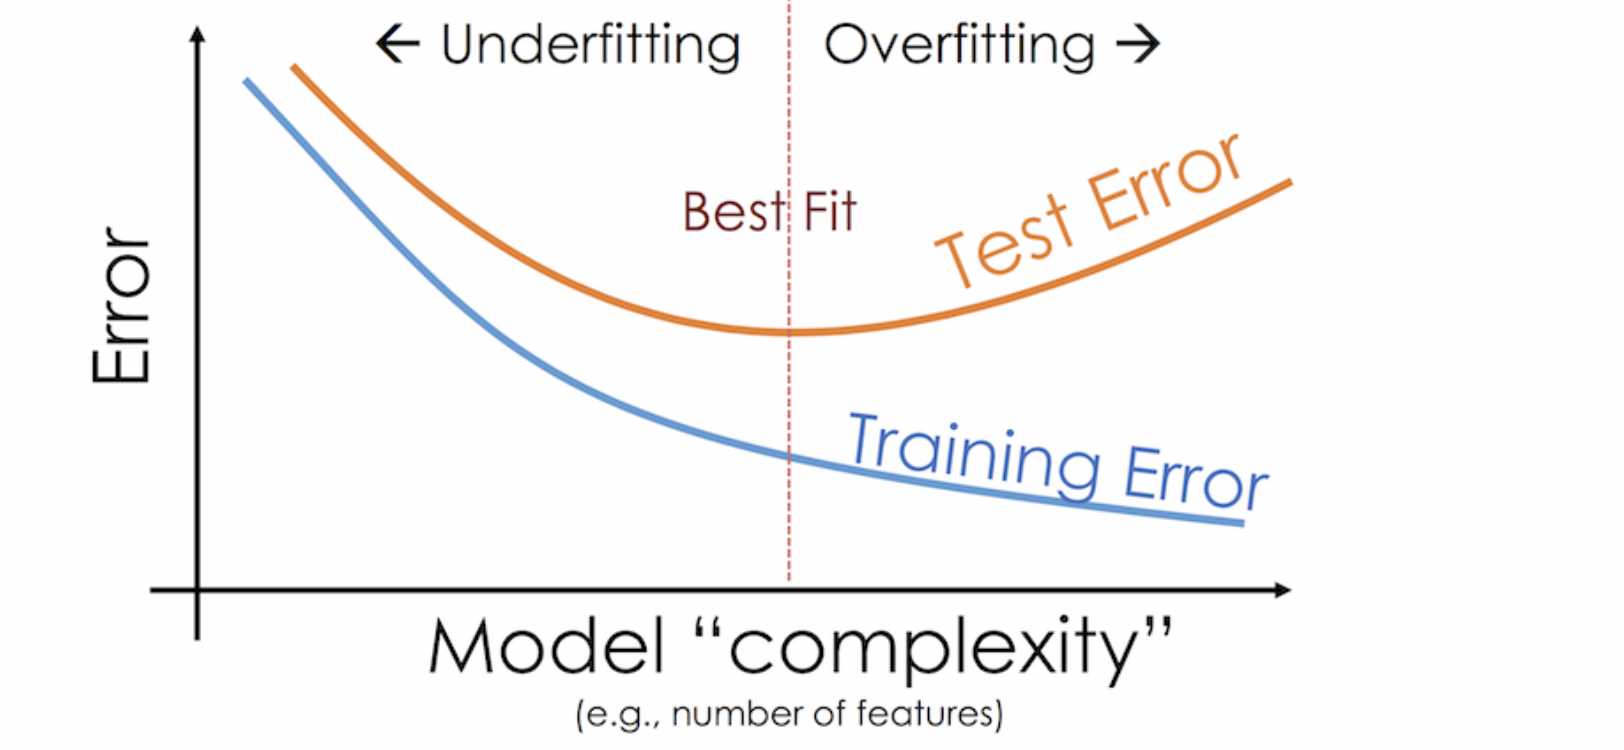

## Review of Cross-Validation

CV is a resampling method that uses different portions of the data to test and train a model on different iterations. One round of CV involves partitioning a sample of data into complementary subsets, performing the analysis on one subset (called the training set), and validating the analysis on the other subset (called the validation set or testing set). To reduce variability, in most methods multiple rounds of cross-validation are performed using different partitions, and the validation results are combined (e.g. averaged) over the rounds to give an estimate of the model's predictive performance. 

There are several forms of CV. This lab will cover:
1. K-fold cross validation
2. Leave-one-out cross validation (LOOCV)
3. Leave-p-out cross validation
4. Repeated k-fold
5. Stratified k-fold
6. Nested k-fold

## CV in sklearn

In this lab, we will be using the `boston` dataset for analysis. This dataset has 506 samples with 13 features, where the target variable is the price of the house. 

### (a) Naive approach: train/test split

Let's start by setting the first 400 observations in the dataset to training set and the rest to test set.

In [1]:
# Load data
import numpy as np
from sklearn.datasets import load_boston
bos = load_boston()

trainsize = 400
y_train = bos.target[:trainsize]
y_test = bos.target[trainsize:]
X_train = bos.data[:trainsize]
X_test = bos.data[trainsize:]
X_train.shape

(400, 13)

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lm = LinearRegression()
model = lm.fit(X_train, y_train)

# Model coefficients
model.coef_

array([-1.91246374e-01,  4.42289967e-02,  5.52207977e-02,  1.71631351e+00,
       -1.49957220e+01,  4.88773025e+00,  2.60921031e-03, -1.29480799e+00,
        4.84787214e-01, -1.54006673e-02, -8.08795026e-01, -1.29230427e-03,
       -5.17953791e-01])

In [3]:
# Model intercept
model.intercept_

28.672599590855498

In [4]:
# Make prediction and calculate MSE
from sklearn.metrics import mean_squared_error

pred = model.predict(X_test)
MSE = mean_squared_error(y_test, pred)
    
print(MSE)

37.89377859960195


A major issue with a simple training/test split is that the training subset could differ a lot from the testing subset and our MSE could end up sensitive to how we split the data. For example, consider set the last 400 observations to the training set instead:

In [5]:
trainsize, n = 400, len(bos.target)
y_train2 = bos.target[(n-trainsize):]
y_test2 = bos.target[:(n-trainsize)]
X_train2 = bos.data[(n-trainsize):]
X_test2 = bos.data[:(n-trainsize)]
X_train2.shape

(400, 13)

In [6]:
model2 = lm.fit(X_train2, y_train2)
model2.coef_

array([-1.09439136e-01,  5.90225894e-02,  5.34583491e-02,  2.53505048e+00,
       -2.12039723e+01,  3.26927486e+00, -3.76800737e-03, -1.78171172e+00,
        3.19717631e-01, -1.25706152e-02, -1.01431662e+00,  9.14542574e-03,
       -5.82146185e-01])

In [7]:
# Model intercept
model2.intercept_

44.683535084390314

In [8]:
pred = model.predict(X_test2)
MSE2 = mean_squared_error(y_test2, pred)

print(MSE2)

12.033653594795043


Despite still maintaining 400 training data and 106 testing, we get a different MSE.

### (b) K-Fold Cross Validation
To deal with the above issue, we consider cross validation. The most commonly used variant of CV is K-fold, where we train and test the model k-times on different subsets of the training data and estimate a performance metric using the test data.
 
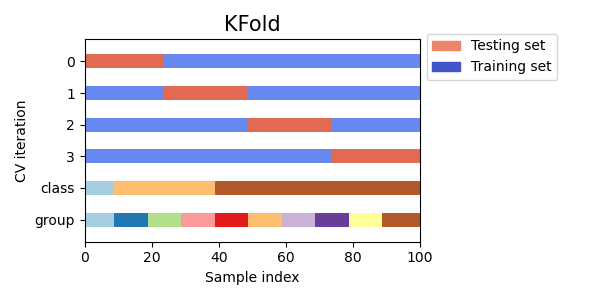

###### Algorithm

1. For some number $k$, split the dataset into k equal folds, if possible

For each unique fold:

> 2. Let the remaining $kâ€“1$ folds form the training set and the fold itself being the test set
3. Using the training set, train the model
4. Using the test set, calculate some sort of performance metric (eg mean squared error, etc)

5. Average the results across the $k$ different folds

**Your task:**
1. Implement 10-fold CV on the entire `boston` dataset 
2. Fit a linear regression for each iteration and store the MSE

In [9]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10)

mse = []
for train_index,test_index in kf.split(bos.data):
    X_train, y_train = bos.data[train_index], bos.target[train_index]
    X_test, y_test = bos.data[test_index], bos.target[test_index]
    model = LinearRegression()
    model.fit(X_train, y_train)
    mse.append(mean_squared_error(y_test, model.predict(X_test)))

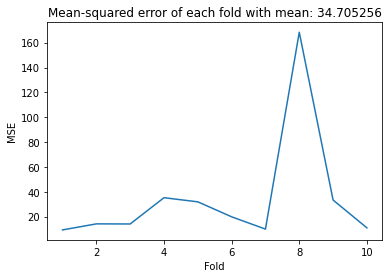

In [10]:
import matplotlib.pyplot as plt
plt.plot(range(1,11,1), mse)
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.title('Mean-squared error of each fold with mean: %f' % np.mean(mse));

An alternative way to get MSE for each fold is to use `cross_val_score` and set `scoring = "neg_mean_squared_error"`. Note that you will need to take the absolute value of the results in order to get MSE.

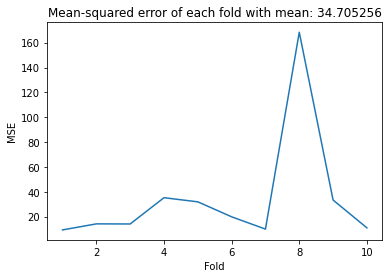

In [11]:
from sklearn.model_selection import cross_val_score
model = LinearRegression()
mse = np.abs(cross_val_score(model, bos.data, bos.target, cv=10, scoring='neg_mean_squared_error'))
plt.plot(range(1,11,1), mse)
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.title('Mean-squared error of each fold with mean: %f' % np.mean(mse));

### (c): Leave-One-Out Cross Validation

The leave-one-out CV (LOOCV) is a special case of the K-fold CV where $k=n$, with $n$ being the number of samples.

**Your task:**
1. Implement LOOCV on the entire `boston` dataset using either `KFold` or `LeaveOneOut` function from sklearn
2. Fit a linear regression for each iteration and store the MSE

In [12]:
# With KFold function
n = len(bos.target) # or n = bos.data.shape[0] (Number of data points)
kf = KFold(n_splits=n)

mse = []
for train_index,test_index in kf.split(bos.data):
    X_train, y_train = bos.data[train_index], bos.target[train_index]
    X_test, y_test = bos.data[test_index], bos.target[test_index]
    model = LinearRegression()
    model.fit(X_train, y_train)
    mse.append(mean_squared_error(y_test, model.predict(X_test)))
np.mean(mse)

23.725745519476096

In [13]:
# With LeaveOneOut function
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

mse = []
for train_index,test_index in loo.split(bos.data):
    X_train, y_train = bos.data[train_index], bos.target[train_index]
    X_test, y_test = bos.data[test_index], bos.target[test_index]
    model = LinearRegression()
    model.fit(X_train, y_train)
    mse.append(mean_squared_error(y_test, model.predict(X_test)))
np.mean(mse)

23.725745519476096

Again, you can use `cross_val_score` function as an alternative way:

In [14]:
loo = LeaveOneOut()
mse = np.abs(cross_val_score(model, bos.data, bos.target, cv=loo, scoring='neg_mean_squared_error'))
np.mean(mse)

23.725745519476096

**Question:** In what scenario will you prefer to use LOOCV than K-Fold CV? When will you prefer K-Fold?

**Answer:** We prefer LOOCV when the data size is small since it will use more training samples in each iteration. That will enable our model to learn better representations. We use k-fold CV when we have a large dataset since LOOCV trains n models, one per sample in the data. When our dataset contains a lot of samples, training so many models will be very computationally expansive.

### (d). Leave-p-Out Cross Validation

An extension of the LOOCV is the LPOCV (Leave-p-out cross validation) that creates all the possible training/test sets by removing $p$ samples from the complete set. Unlike with LOOCV or K-fold, the test sets will overlap when $p>1$. When $p=1$, naturally this reduces to the LOOCV.

###### Algorithm

1. Consider all possible combinations of choosing $p$ samples out of the total $n$

For each combination: 

> 2. Let the $p$ samples from the dataset form the test set and the remaining $n â€“ p$ samples be the training set
3. Using the training set, train the model
4. Using the test set, calculate some sort of performance metric (eg mean squared error, etc)

5. Average the results across the ${n \choose p}$ different combinations

Let's look at an illustration on how LPOCV works on a small dummy dataset:

In [15]:
X, y = np.array([[1,2], [3,4], [5,6], [7,8]]), np.array([1,2,3,4])
X, y

(array([[1, 2],
        [3, 4],
        [5, 6],
        [7, 8]]),
 array([1, 2, 3, 4]))

In [16]:
from sklearn.model_selection import LeavePOut

lpo = LeavePOut(2)

In [17]:
import math

def nCr(n,r):
    f = math.factorial
    return f(n) / f(r) / f(n-r)

nCr(4,2)

6.0

In [18]:
for train_index, test_index in lpo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [2 3] TEST: [0 1]
TRAIN: [1 3] TEST: [0 2]
TRAIN: [1 2] TEST: [0 3]
TRAIN: [0 3] TEST: [1 2]
TRAIN: [0 2] TEST: [1 3]
TRAIN: [0 1] TEST: [2 3]


In [19]:
lpo = LeavePOut(3)
nCr(4,3)

4.0

In [20]:
for train_index, test_index in lpo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [3] TEST: [0 1 2]
TRAIN: [2] TEST: [0 1 3]
TRAIN: [1] TEST: [0 2 3]
TRAIN: [0] TEST: [1 2 3]


This method can be exhaustive and computationally expensive because it needs to train and validate the model for all possible combinations. When $p$ is large, LPOCV can become computationally infeasible.

### (e). Repeated k-Fold:

We've seen above that the k-fold cross-validation procedure divides the dataset into $k$ non-overlapping folds. Repeated K-fold simply repeats K-Fold $t$ times, for some preselected $t$. On every iteration from 1 to $t$, we randomly choose a different partition for the K-fold. We average across all folds and all repeats generated across the $t$ iterations.

In [21]:
from sklearn.model_selection import RepeatedKFold

# k=2, t=5
rkf = RepeatedKFold(n_splits=2, n_repeats=10, random_state=42)

t = 0
for i, (train_index, test_index) in enumerate(rkf.split(X)):
    if i % 2 == 0:
        t += 1
        print('t = %f' % t)
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

t = 1.000000
TRAIN: [0 2] TEST: [1 3]
TRAIN: [1 3] TEST: [0 2]
t = 2.000000
TRAIN: [0 2] TEST: [1 3]
TRAIN: [1 3] TEST: [0 2]
t = 3.000000
TRAIN: [1 2] TEST: [0 3]
TRAIN: [0 3] TEST: [1 2]
t = 4.000000
TRAIN: [2 3] TEST: [0 1]
TRAIN: [0 1] TEST: [2 3]
t = 5.000000
TRAIN: [0 3] TEST: [1 2]
TRAIN: [1 2] TEST: [0 3]
t = 6.000000
TRAIN: [2 3] TEST: [0 1]
TRAIN: [0 1] TEST: [2 3]
t = 7.000000
TRAIN: [0 1] TEST: [2 3]
TRAIN: [2 3] TEST: [0 1]
t = 8.000000
TRAIN: [1 3] TEST: [0 2]
TRAIN: [0 2] TEST: [1 3]
t = 9.000000
TRAIN: [0 1] TEST: [2 3]
TRAIN: [2 3] TEST: [0 1]
t = 10.000000
TRAIN: [1 3] TEST: [0 2]
TRAIN: [0 2] TEST: [1 3]


**Question:** What are the pros and cons of using repeated k-Fold instead of standard k-Fold CV? 

**Answer:** 
- Pros: As what we discussed earlier, different splits of the data may result in very different results. The standard K-fold CV can therefore be sensitive to the exact partition of the folds. Repeated CV can reduce the noisiness from a single k-Fold split.

- Cons: Repeated k-Fold can be computationally expensive due to the high amounts of iterations.

### (f) Stratified k-Fold: 


For some datasets, there may be a huge amount of imbalance in the outcome variables (eg in a dataset about price of cars, there might be large number of cars that all have a high price). In such a case, we may wish to preserve the imbalance within the individual folds. One solution is to use stratified K-Fold, a variation of CV such that each fold contains approximately the same percentage of samples of each specific target class as the complete set.

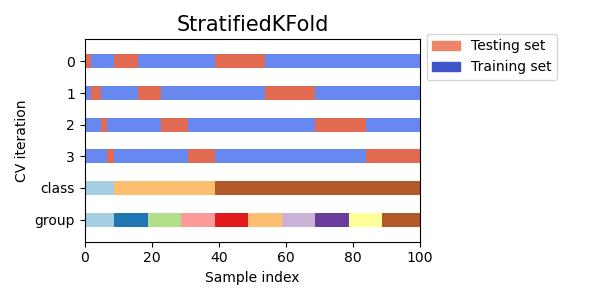

###### Algorithm

1. For some number $k$, split the dataset into k folds, with each fold containing approximately the same percentage of samples of each target class as the complete set 

For each unique fold:

> 2. Let the remaining $kâ€“1$ folds to form the training set and the fold itself be the test set
3. Using the training set, train the model
4. Using the test set, calculate some sort of performance metric (eg mean squared error, etc)

5. Average the results across the $k$ different folds

In [22]:
X, y = np.ones((20, 1)), np.hstack(([0] * 14, [1] * 6))
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

In [23]:
# Percentage of label 1 in y
np.mean(y)

0.3

In [24]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=3)

In [25]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print('-'*53)
    print('Fold: ', i)
    print("TRAIN:", train_index)
    print("TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print('Percentage of 1 in train: %f' % np.mean(y_train))
    print('Percentage of 1 in test: %f' % np.mean(y_test))

-----------------------------------------------------
Fold:  0
TRAIN: [ 5  6  7  8  9 10 11 12 13 16 17 18 19]
TEST: [ 0  1  2  3  4 14 15]
Percentage of 1 in train: 0.307692
Percentage of 1 in test: 0.285714
-----------------------------------------------------
Fold:  1
TRAIN: [ 0  1  2  3  4 10 11 12 13 14 15 18 19]
TEST: [ 5  6  7  8  9 16 17]
Percentage of 1 in train: 0.307692
Percentage of 1 in test: 0.285714
-----------------------------------------------------
Fold:  2
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 14 15 16 17]
TEST: [10 11 12 13 18 19]
Percentage of 1 in train: 0.285714
Percentage of 1 in test: 0.333333


We can see that 14-15, 16-17 and 18-19, which all have values of 1, are stratified into different testing sets during cross validation.

### (g) Nested Cross Validation:

Recall in Lab 1, we're interested in tuning the specific regularization parameter $\lambda$ for Ridge and LASSO regression. 

Generally, there are many situations where we wish to tune a hyperparameter while simultaneously evaluating a model using cross validation. When the same cross-validation procedure and dataset are used to both tune and select a model, it is likely to lead to an optimistically biased evaluation of the model performance. As a result, we consider nested CV.

Nested CV uses a series of train/validation/test set splits consisting of an inner loop for the hyperparameter and an outer loop to calculate the performance metric (eg mean squared error, etc). Within the inner loop, the score is approximately maximized by fitting a model to each training set and then directly maximized in selecting hyperparameters over the validation set. In the outer loop, we calculate the metric by averaging across test set scores over several dataset splits.

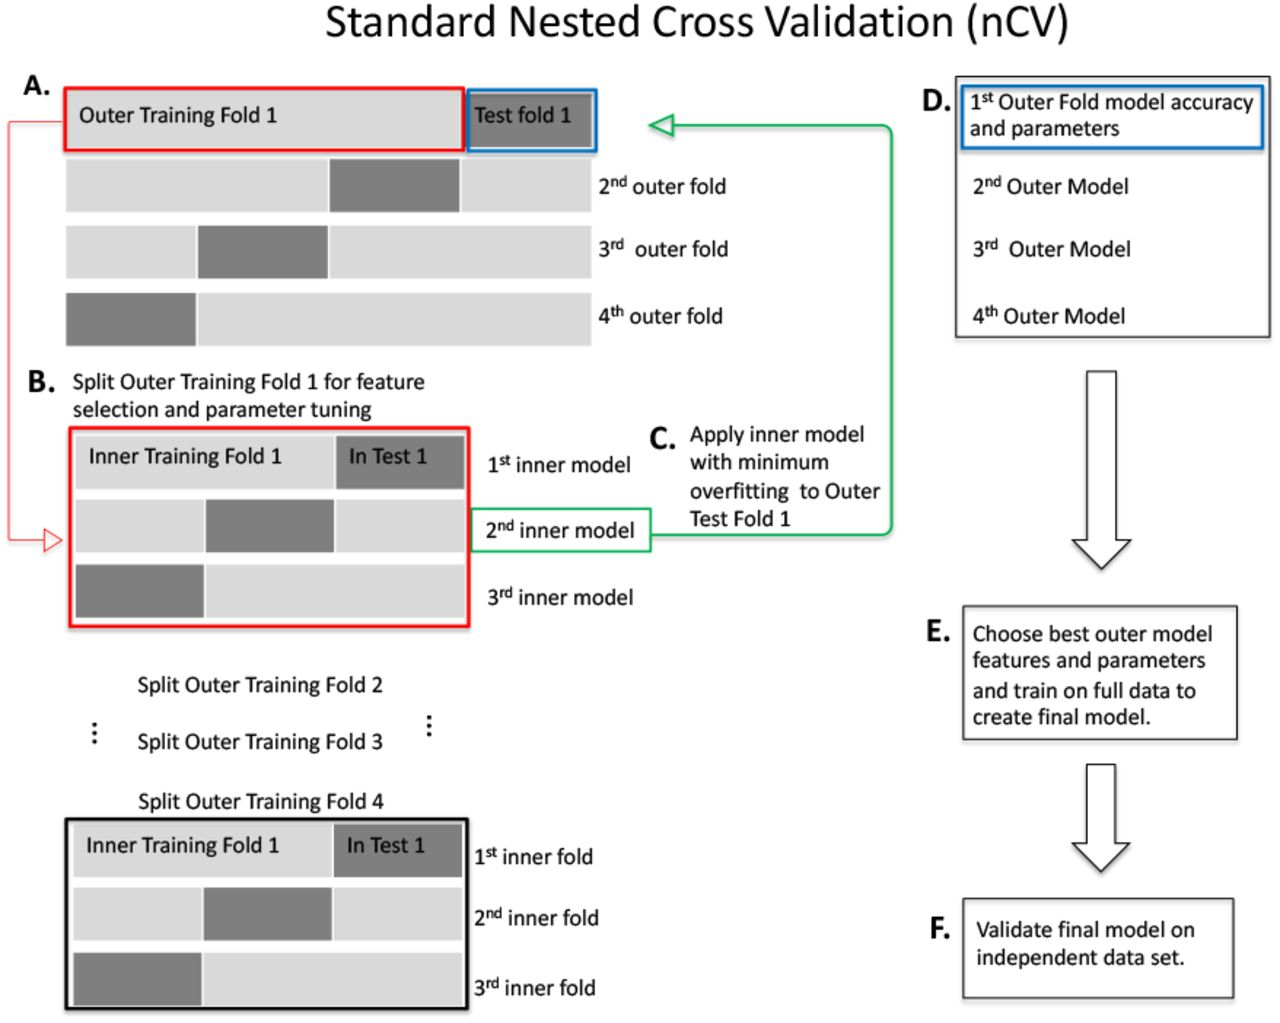

###### Algorithm

1. Pick a number $k$ number of folds and a parameter $p$ (assume it takes $d$ possible values) that we are trying to optimize.
2. Divide the dataset into $k$ folds.

For each unique of the $k$ fold:

> 3. For each possible value of $p$ and unique fold from the $k-1$ remaining, evaluate the performance metric, for a total of $(k-1)*d$ measurements
4.Choose $p$ that minimizes the average training error and use that $p$ to evaluate on the test set, which is the pre-selected unique fold

The algorithm that performed the best was the one with the best average out-of-sample performance across the k test folds

In [26]:
from sklearn.linear_model import Lasso

lasso = Lasso()
p_grid = {"alpha": [.0001, .001, .01, .1, .3, .9]}

In [27]:
# Code adapted from sklearn documentation:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html#

from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

# Try 30 different random seeds
NUM_TRIALS = 30

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=lasso, param_grid=p_grid, cv=inner_cv, scoring='neg_mean_squared_error')
    clf.fit(bos.data, bos.target)
    non_nested_scores[i] = np.abs(clf.best_score_)

    # Nested CV with parameter optimization
    ## Inner loop
    clf = GridSearchCV(estimator=lasso, param_grid=p_grid, cv=inner_cv, scoring='neg_mean_squared_error')
    ## Outer loop
    nested_score = np.abs(cross_val_score(clf, X=bos.data, y=bos.target, 
                                          cv=outer_cv, scoring='neg_mean_squared_error'))
    nested_scores[i] = nested_score.mean()

score_difference = nested_scores - non_nested_scores

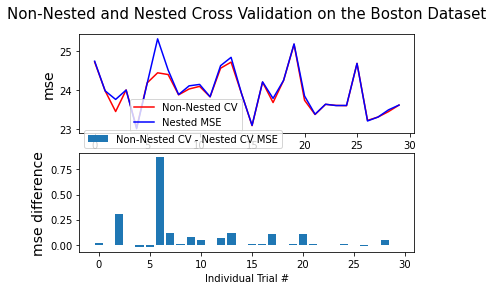

In [28]:
# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
non_nested_scores_line, = plt.plot(non_nested_scores, color='r')
nested_line, = plt.plot(nested_scores, color='b')
plt.ylabel("mse", fontsize="14")
plt.legend([non_nested_scores_line, nested_line],
           ["Non-Nested CV", "Nested MSE"],
           bbox_to_anchor=(0, .4, .5, 0))
plt.title("Non-Nested and Nested Cross Validation on the Boston Dataset",
          x=.5, y=1.1, fontsize="15")

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend([difference_plot],
           ["Non-Nested CV - Nested CV MSE"],
           bbox_to_anchor=(0, 1, .8, 0))
plt.ylabel("mse difference", fontsize="14")

plt.show()